In [2]:
#Install Keras & Tensorflow
!pip install --upgrade tensorflow
!pip install Keras
!pip install keras-tqdm

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.14.0)
--2019-07-09 09:18:21--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  28.1MB/s    in 45s     

2019-07-09 09:19:08 (27.9 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [3]:
import pickle
import numpy as np
import pandas as pd


idx = 0
vocab = {}
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 2
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            vocab["__UNK__"] = 1
            idx = 2
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("fasttext_voc",'wb'))
    np.save("fasttext.npy",vecs)
    
fasttext_embed = np.load("fasttext.npy")
fasttext_word_to_index = pickle.load(open("fasttext_voc", 'rb'))

!wget https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

--2019-07-09 09:31:39--  https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44319561 (42M) [text/csv]
Saving to: ‘stack-overflow-data.csv’

stack-overflow-data 100%[===================>]  42.27M  77.0MB/s    in 0.5s    

2019-07-09 09:31:40 (77.0 MB/s) - ‘stack-overflow-data.csv’ saved [44319561/44319561]



In [3]:
import numpy as np
import pickle

fasttext_embed = np.load("fasttext.npy")
fasttext_word_to_index = pickle.load(open("fasttext_voc", 'rb'))

In [4]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [5]:
import pandas as pd

data = pd.read_csv('stack-overflow-data.csv')

Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)
print(data['tags'].value_counts())

css              2000
python           2000
asp.net          2000
angularjs        2000
java             2000
c                2000
.net             2000
objective-c      2000
html             2000
iphone           2000
c#               2000
ruby-on-rails    2000
javascript       2000
android          2000
c++              2000
jquery           2000
sql              2000
php              2000
mysql            2000
ios              2000
Name: tags, dtype: int64


In [6]:
data['post']

0        what is causing this behavior  in our c# datet...
1        have dynamic html load as if it was in an ifra...
2        how to convert a float value in to min:sec  i ...
3        .net framework 4 redistributable  just wonderi...
4        trying to calculate and print the mean and its...
5        how to give alias name for my website  i have ...
6        window.open() returns null in angularjs  it wo...
7        identifying server timeout quickly in iphone  ...
8        unknown method key  error in rails 2.3.8 unit ...
9        from the include  how to show and hide the con...
10       when we need interface c# <blockquote>    <str...
11       how to install .ipa on jailbroken iphone over ...
12       dynamic textbox text - asp.net  i m trying to ...
13       rather than bubblesorting these names...the pr...
14       site deployed in d: drive and uploaded files a...
15       connection in .net  i got     <blockquote>    ...
16       how to subtract 1 from an int  how do i subtra.

In [7]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
def preprocess_full_dataset(df):
    """
    The data preprocessing of the full dataset. 
    :param df (pandas.DataFrame):  The dataframe of the loaded Dataset
    :param input_ins:
    :return:
    """
    df['tags'] = pd.Categorical(df.tags)

    # convert text to lowercase
    df['post'] = df['post'].str.lower()

    # remove numbers
    df['post'] = df['post'].str.replace("[0-9]", " ")

    # # # remove stopwords
    stop_words = stopwords.words('english')
    df['post'] = (df['post'].apply(lambda text: ' '.join([word.strip() for word in text.split()
                                                          if word not in stop_words])))

    # remove links
    links_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    df['post'] = df['post'].apply(lambda text: re.sub(links_regex, "", text))

    # remove punctuation characters
    punc_reqex = '[!,.:;-](?= |$)'
    df['post'] = df['post'].apply(lambda text: re.sub(punc_reqex, r'', text))


    return df

[nltk_data] Downloading package stopwords to /home/hard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
data=preprocess_full_dataset(data)

In [9]:
data['totalwords'] = data['post'].str.split().str.len()
data['totalwords'].sum(axis=0)/data['totalwords'].size


94.7004

In [10]:
data['totalwords'].max(axis=0)

2924

In [11]:
Y=pd.get_dummies(data['tags']).values

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer 
import itertools
from sklearn.model_selection import train_test_split

X_Full_train, X_test, Y_Full_train, y_test = train_test_split(data['post'],Y,
                                    test_size=0.3,
                                    random_state=1596)

X_train, X_train_dev, y_train, y_train_dev = train_test_split(X_Full_train,Y_Full_train,
                                    test_size=0.2,
                                    random_state=1596)

#X_train =train['post']
#X_test = test['post']
#X_train_dev = train_dev['post']

#y_train = mlb.fit_transform(train['tags'])
#y_test = mlb.transform(test['tags'])
#y_train_dev = mlb.transform(train_dev['tags'])

In [13]:
y_test.shape

(12000, 20)

In [14]:
# Convert texts to sequence of indexes and PADDING

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_WORDS =20000
MAX_SEQUENCE_LENGTH = 600
EMBEDDING_DIM = fasttext_embed.shape[1]

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
tokenizer.fit_on_texts(X_train)
train_seqs = tokenizer.texts_to_sequences(X_train)
test_seqs = tokenizer.texts_to_sequences(X_test)
dev_seqs = tokenizer.texts_to_sequences(X_train_dev)
train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

In [15]:
print(train_data[0])

[4045 3180 1617  124  801  566   53 1617 1052  566 1263  124 3632   55
 1206 1845    1 5428   60  124  128 1353   55   27 1617  124  801 3504
 5693  566  801   53 1617  124 1052  566  494  124 1580 1313  209  111
   80  434  757    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [16]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 80754 unique tokens.


In [17]:
# Define model's embedding matrix
embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

In [18]:
y_train.shape

(22400, 20)

In [19]:
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers.core import Layer
import numpy as np


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class LinearAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, bias_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(LinearAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        
        # eij = Wx + b
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        # a = softmax(eij)
        a = K.expand_dims(K.softmax(eij, axis=-1))
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b1 = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
        else:
            self.b1 = None
            self.b2 = None

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [21]:
#Create and train a BiGRU (RNN) model with an MLP on top of it 

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers.recurrent import GRU
from keras.optimizers import Adam
from keras import backend as K


GRU_SIZE = 200
DENSE = 300
N_CLASSES = 20

# create empty sequential model
model = Sequential()
# add an embedding layer
model.add(Embedding(MAX_WORDS+2, EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
# Use 0.2 dropout probabillity
model.add(Dropout(0.2))
# add a bidirectional gru layer with 0.2 variational (recurrent) dropout 
model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=False, recurrent_dropout = 0.2)))
# add a hidden MLP layer
model.add(Dropout(0.2))
model.add(Dense( DENSE, activation='tanh' ))
# add the output MLP layer
model.add(Dense( N_CLASSES, activation='softmax' ))

print(model.summary())
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_BiGRU_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')



history = model.fit(train_data, y_train,
              batch_size=64,
              epochs=10,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(dev_data, y_train_dev),
              shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400)               601200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_6 (Dense)              (None, 20)                6020      
Total params: 6,728,120
Trainable params: 727,520
Non-trainable params: 6,000,600
____________________________________________________________


Epoch 00001: val_f1 improved from -inf to 0.62258, saving model to keras_BiGRU_model



Epoch 00002: val_f1 improved from 0.62258 to 0.72474, saving model to keras_BiGRU_model



Epoch 00003: val_f1 improved from 0.72474 to 0.75952, saving model to keras_BiGRU_model



Epoch 00004: val_f1 improved from 0.75952 to 0.77378, saving model to keras_BiGRU_model



Epoch 00005: val_f1 improved from 0.77378 to 0.79079, saving model to keras_BiGRU_model



Epoch 00006: val_f1 improved from 0.79079 to 0.79864, saving model to keras_BiGRU_model



Epoch 00007: val_f1 improved from 0.79864 to 0.80354, saving model to keras_BiGRU_model



Epoch 00008: val_f1 improved from 0.80354 to 0.80885, saving model to keras_BiGRU_model



Epoch 00009: val_f1 improved from 0.80885 to 0.81359, saving model to keras_BiGRU_model



Epoch 00010: val_f1 did not improve from 0.81359


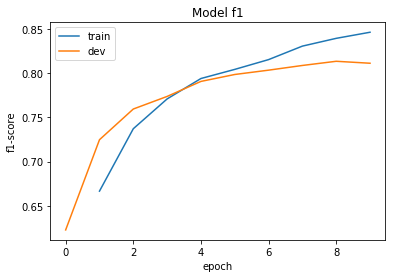

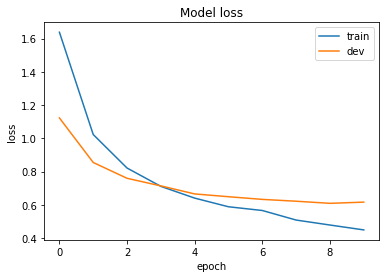

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [25]:
from sklearn import metrics

y_prob = model.predict(test_data, batch_size=32, verbose=0)
print(metrics.classification_report(y_test, (y_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.83      0.63      0.72       586
           1       0.85      0.89      0.87       578
           2       0.98      0.96      0.97       625
           3       0.86      0.78      0.82       594
           4       0.86      0.81      0.84       634
           5       0.69      0.61      0.65       619
           6       0.92      0.68      0.78       628
           7       0.84      0.89      0.87       575
           8       0.82      0.70      0.75       601
           9       0.79      0.49      0.61       627
          10       0.72      0.64      0.68       584
          11       0.95      0.76      0.85       627
          12       0.87      0.76      0.81       627
          13       0.91      0.82      0.87       620
          14       0.93      0.76      0.84       561
          15       0.85      0.55      0.67       609
          16       0.96      0.77      0.86       600
          17       0.95    

### BiGRU with Deep self-attention and MLP

In [27]:
#Create and train a BiGRU (RNN) model with an MLP on top of it 

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Bidirectional, Input
from keras.layers.recurrent import GRU
from keras.optimizers import Adam
from keras import backend as K



GRU_SIZE = 200
DENSE = 300
N_CLASSES = 20


inputs = Input((MAX_SEQUENCE_LENGTH,))

# Add an embedding layer with 0.2 dropout probability
embeddings = Embedding(MAX_WORDS+2,EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
drop_emb = Dropout(0.2)(embeddings)

# add a bidirectional gru layer with 0.2 variational (recurrent) dropout 
bigru = Bidirectional(GRU(GRU_SIZE, return_sequences=True, recurrent_dropout = 0.2))(drop_emb)
print(bigru.shape)

#add a deep self attention layer
x, attn = DeepAttention(return_attention=True)(bigru)

# add a hidden MLP layer
drop = Dropout(0.2)(x)
out = Dense(DENSE, activation="tanh")(x)

# add the output MLP layer
out = Dense(N_CLASSES, activation="softmax")(out)
model = Model(inputs, out)

print(model.summary())
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_BiGRU_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')



history = model.fit(train_data, y_train,
              batch_size=64,
              epochs=10,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(dev_data, y_train_dev),
              shuffle=True)

(?, ?, 400)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 600, 400)          601200    
_________________________________________________________________
deep_attention_6 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_6 (Dense)              (None, 20)                6020     


Epoch 00001: val_f1 improved from -inf to 0.68156, saving model to keras_BiGRU_model



Epoch 00002: val_f1 improved from 0.68156 to 0.76477, saving model to keras_BiGRU_model



Epoch 00003: val_f1 improved from 0.76477 to 0.78196, saving model to keras_BiGRU_model



Epoch 00004: val_f1 improved from 0.78196 to 0.79277, saving model to keras_BiGRU_model



Epoch 00005: val_f1 improved from 0.79277 to 0.81167, saving model to keras_BiGRU_model



Epoch 00006: val_f1 improved from 0.81167 to 0.81500, saving model to keras_BiGRU_model



Epoch 00007: val_f1 improved from 0.81500 to 0.81578, saving model to keras_BiGRU_model



Epoch 00008: val_f1 improved from 0.81578 to 0.81695, saving model to keras_BiGRU_model



Epoch 00009: val_f1 improved from 0.81695 to 0.82325, saving model to keras_BiGRU_model



Epoch 00010: val_f1 did not improve from 0.82325



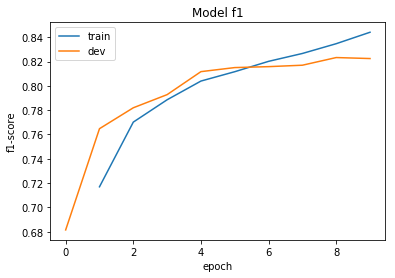

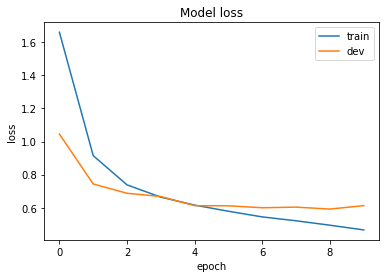

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [29]:
from sklearn import metrics

y_prob = model.predict(test_data, batch_size=32, verbose=0)
print(metrics.classification_report(y_test, (y_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.79      0.67      0.73       586
           1       0.94      0.86      0.90       578
           2       0.99      0.97      0.98       625
           3       0.90      0.75      0.82       594
           4       0.86      0.82      0.84       634
           5       0.70      0.61      0.65       619
           6       0.87      0.76      0.81       628
           7       0.86      0.85      0.86       575
           8       0.75      0.78      0.76       601
           9       0.79      0.56      0.65       627
          10       0.76      0.62      0.68       584
          11       0.94      0.81      0.87       627
          12       0.78      0.84      0.81       627
          13       0.98      0.65      0.78       620
          14       0.92      0.79      0.85       561
          15       0.87      0.54      0.66       609
          16       0.95      0.79      0.86       600
          17       0.97    